In [ ]:
# Check GPU
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU: []


In [ ]:
!pip install -q tensorflow-datasets
!pip install -q scikit-learn opencv-python

import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2


In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'oxford_iiit_pet:4.0.0',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.U7YF7O_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.U7YF7O_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds  = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [ ]:
# ================================
# 5. CNN Model Building
# ================================
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import MobileNetV2

# Get number of classes from dataset info
NUM_CLASSES = ds_info.features['label'].num_classes

# Define input
inputs = Input(shape=(224, 224, 3))

# Load base model (without top)
base_model = MobileNetV2(include_top=False,
                         weights="imagenet",
                         input_tensor=inputs)

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

# Final model
model = Model(inputs, outputs)

# Show model summary
model.summary()


/tmp/ipython-input-2869361621.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,305,381 (8.79 MB)

 Trainable params: 47,397 (185.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ================================
# 6. Compile & Train the Model
# ================================
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)


Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.0709 - loss: 3.7533 - val_accuracy: 0.2944 - val_loss: 2.7144
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.3004 - loss: 2.5762 - val_accuracy: 0.5857 - val_loss: 1.9469
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - accuracy: 0.5339 - loss: 1.8862 - val_accuracy: 0.7187 - val_loss: 1.4649
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.6552 - loss: 1.4377 - val_accuracy: 0.7724 - val_loss: 1.1707
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - accuracy: 0.7326 - loss: 1.1303 - val_accuracy: 0.8068 - val_loss: 0.9824


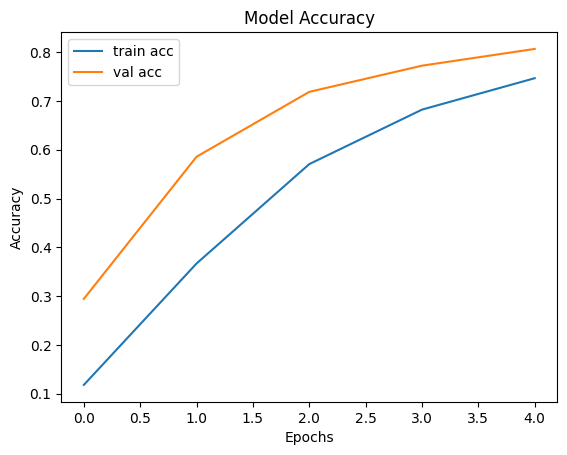

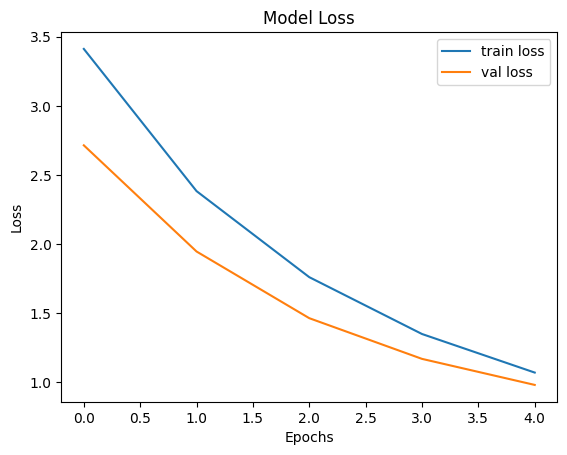

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


115/115 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.8147 - loss: 0.9675
Test Accuracy: 80.68%
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/

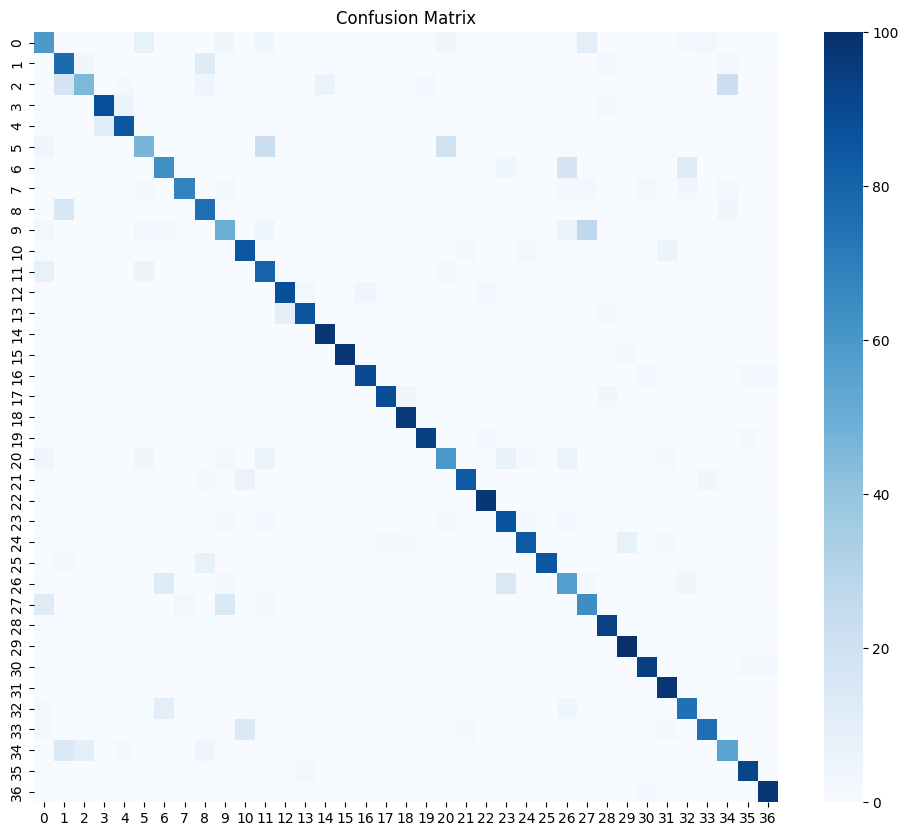

In [ ]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc*100:.2f}%")

# Predictions
y_true, y_pred = [], []
for imgs, labels in test_ds:
    preds = model.predict(imgs)
    preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(preds.tolist())

print(classification_report(y_true, y_pred, target_names=ds_info.features['label'].names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files

def predict_image(path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = image.img_to_array(img) / 255.0
    preds = model.predict(np.expand_dims(arr, 0))
    idx = np.argmax(preds[0])
    return ds_info.features['label'].int2str(idx), float(np.max(preds))

uploaded = files.upload()
for fn in uploaded.keys():
    label, conf = predict_image(fn)
    print(f"Prediction: {label} ({conf:.2f})")


Saving Screenshot 2025-09-27 222729.png to Screenshot 2025-09-27 222729 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Prediction: Bombay (0.26)


In [ ]:
# Save the trained model
model.save("pet_monitoring_cnn_model.keras")


In [ ]:


!ls




 pet_monitoring_cnn_model.keras     'Screenshot 2025-09-27 222729 (1).png'
 sample_data			    'Screenshot 2025-09-27 222729.png'
'Screenshot 2025-09-27 222539.png'


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds

model = load_model("pet_monitoring_cnn_model.keras")
IMG_SIZE = 224
ds_info = tfds.builder("oxford_iiit_pet:4.0.0").info


In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np

def predict_image(path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = image.img_to_array(img) / 255.0
    preds = model.predict(np.expand_dims(arr, 0))
    idx = np.argmax(preds[0])
    return ds_info.features['label'].int2str(idx), float(np.max(preds))


In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
    label, conf = predict_image(fn)
    print(f"Prediction: {label} ({conf:.2f})")


Saving Screenshot 2025-09-27 222729.png to Screenshot 2025-09-27 222729 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Bombay (0.26)


In [ ]:
!ls


 pet_monitoring_cnn_model.keras     'Screenshot 2025-09-27 222729 (1).png'
 pet_monitoring_system.zip	    'Screenshot 2025-09-27 222729 (2).png'
 sample_data			    'Screenshot 2025-09-27 222729.png'
'Screenshot 2025-09-27 222539.png'


In [ ]:
!zip -r pet_monitoring_system_full.zip pet_monitoring_system.ipynb pet_monitoring_cnn_model.keras


	zip warning: name not matched: pet_monitoring_system.ipynb
  adding: pet_monitoring_cnn_model.keras (deflated 12%)


In [ ]:
from google.colab import files
files.download("pet_monitoring_system_full.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()  # select pet_monitoring_system.ipynb from your computer



Saving pet_monitoring_system.ipynb to pet_monitoring_system.ipynb


In [ ]:
!zip -r pet_monitoring_system_full.zip pet_monitoring_system.ipynb pet_monitoring_cnn_model.keras


updating: pet_monitoring_cnn_model.keras (deflated 12%)
  adding: pet_monitoring_system.ipynb (deflated 79%)


In [ ]:
from google.colab import files
files.download("pet_monitoring_system_full.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>